# Tuning a PID controller
In this notebook we'll try out PID tuning according to the method presented by ABB [here](https://youtu.be/3viD5ij60EI). You should watch this video first. 

The idea of PID tuning is that you can find parameters for your controller from simple experiments on the plant. The dynamics of the plant is described by a few (typically 2 or 3) parameters only, and from these few parameters the PID parameters are determined from a look-up table. We will do it by hand, but many commercial controllers have functions that will perform tuning automatically by the press of a button.

The disadvantage of these simple PID tuning rules is that with such a simplified model of the plant dynamics, performance may not be optimal.   

## Blockdiagram
We consider the problem of velocity control of a car (cruise control). The plant model describes how the velocity of the car responds to the position of the accelerator (the gas pedal). In addition to the signal from the accelerator, there are also unknown and varying forces acting on the car such as wind resistance and gravity when the car is going uphill or downhill. These forces are represented by a disturbance signal entering at the input to the system. 

<!--- ![Block diagram of cruise control system](cruise-control-vel-pid-block.svg) -->
<img src="cruise-control-vel-pid-block.svg" alt="Block diagram of cruise control system" width="900">

## The PID controller
The PID-controller is on the standard form 
\begin{equation}
F(s) = K_c \left( 1  + \frac{1}{T_i s} + T_d s \right).
\end{equation}



In [ ]:
# If you are missing some of the required packages, then, in Juliabox go to the Console-tab and do the following:
#  1. Start a julia session: 
#      user@juliabox:~$ julia 
#  2. Add the packages by running the package manager:
#      julia> Pkg.add("ControlSystems") 
#      julia> Pkg.add("Interact") 
#      julia> Pkg.add("Gadfly") 
#      julia> Pkg.update() 


In [2]:
using Interact
using ControlSystems
using Gadfly

## Step response of the plant
Below is a step-response of the plant to a unit step input in $\theta$. The actual transfer function of the car can be read from the code below, but assume for now that you know nothing more about the plant dynamics than what the step response is telling you.

In the plot you need to identify
1. The process gain $K_p$. You get this from the steady state value of the output signal.
2. The time constant $\tau_p$ which can be approximated by the settling time divided by four

There is some noise added to the input to the system to make the task a bit harder :-)

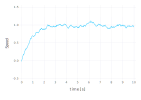

In [3]:
# Define the plant
G1 = tf([1.], [1, 1.]);

# Create time vector
N = 600;
t = collect(linspace(0, 10, N)); # 60 values per second 

# Create the step input signal 
θ = ones(N);

# Simulate disturbance (white noise)
d = 0.6*randn(N);

# Simulate step response
y, t_out, x = lsim(G1, θ+d, t); # Note the noise added to the input


# Simulated 
plot(x=t, y=y, Geom.line, Guide.xticks(ticks=collect(linspace(0,10,11))), Guide.xlabel("time [s]"), Guide.ylabel("Speed"))

## The PID parameters
There is a user-chosen parameter in this particular tuning rule: The so-called $\tau_{ratio}$. The purpose of this parameter is to set the "aggressiveness" of the controller, i.e. how fast the closed-loop system should be with respect to how fast the plant is. Its definition is the ratio between the time constant of the closed-loop and and the time constant of the plant.
$$ \tau_{ratio} = \frac{\tau_c}{\tau_p}. $$

The suggested guide line from the video is

| $\tau_{ratio}$ | Closed loop response |
|---------------|----------------------|
| 1             | Faster               |
| 2             | Fast                 |
|  3            | Safe                 |
|  4            | Slow                 |

The chosen value for the ratio does not have to be integer-valued of course. 

Once a value for the $\tau_{ratio}$ has been decided, the other parameters can then be determined as
$$ K_c = \frac{1}{K_p \tau_{ratio}} $$
$$ T_i = \tau_p $$
$$ T_d = 0. $$


## Tune your PID controller
1. Determine the parameters $K_p$ and $\tau_p$ from the step response of the plant.
2. Decide a value for $\tau_{ratio}$.
3. Determine the PID parameters from the tuning rule above.

## Step response of the closed-loop system
In the below plot you can test your tuned parameters.

Interact.Slider{Float64}(Signal{Float64}(5.0, nactions=0),"Kc",5.0,0.0:0.1:10.0,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(2.5, nactions=0),"Ti",2.5,0.0:0.1:5.0,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(2.5, nactions=0),"Td",2.5,0.0:0.1:5.0,".3f",true)

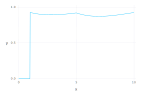

In [4]:
G = tf([1.], [1, 1.]);

N = 600;
t = collect(linspace(0, 10, N)); # 60 values per second 

# The reference signal
r = zeros(N);
r[round(Int,N/10):end] = 1.0;

# The disturbance signal
d = zeros(N);
d[round(Int,N/10)*5:end] = -1.0;

@manipulate for Kc in 0:0.1:10, Ti in 0:0.1:5, Td in 0:0.1:5
    F = minreal(Kc*tf([Td, 1, 1/Ti], [1.0, 0]));
    Gr = minreal(feedback(G*F));
    Gd = minreal(feedback(G*F)/F);
    yr, t_out, x = lsim(Gr, r, t);
    yd, t_out, x = lsim(Gd, d, t);
    stp = plot(x=t, y=(yr+yd), Geom.line)
end

## Further reading
- [Documentation for the ControlSystem package](http://juliacontrol.github.io/ControlSystems.jl/latest/)
- [PID control on Wikipedia](https://en.wikipedia.org/wiki/PID_controller)
